**Generalized State-Feedback Controller Synthesis for Underactuated Systems through Bayesian Optimization**

Miguel A. Solis and Sinnu Susan Thomas

*submitted to IEEE Access* (under review, file is intende to serve as supplementary material for reviewers)

In [ ]:
!pip install GPy GPyOpt
!pip install control
import control
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
import numpy as np
import sys
import matplotlib.pyplot as plt

In [ ]:
Bc, Cc = np.zeros((1,5)), -0.5

def myf(params):
    param1 = np.array(params[0][0])
    param2 = np.array(params[0][1:])
    Abar = np.block([[A-B*param2, -B*Cc], [Bc, param1]])
    eigenvalues = np.linalg.eig(Abar)[0].real
    inf_norm = np.linalg.norm(eigenvalues, float("inf"))
    if (eigenvalues < 0).all():
        print("Feasible parameters:")
        print("Ac: ", param1)
        print("Dc: ", param2)
        print("Eigenvalues: ", eigenvalues)
    return inf_norm

In [ ]:
bounds = [{'name': 'A_c', 'type': 'continuous', 'domain': (-100,100)},
          {'name': 'D_c1', 'type': 'continuous', 'domain': (-100,100)},
          {'name': 'D_c2', 'type': 'continuous', 'domain': (-100,100)},
          {'name': 'D_c3', 'type': 'continuous', 'domain': (-100,100)},
          {'name': 'D_c4', 'type': 'continuous', 'domain': (-100,100)},
          {'name': 'D_c5', 'type': 'continuous', 'domain': (-100,100)} ]

A = np.array([[0, 1, 0, 0, 0],[0, -0.31, 2.99, -0.02, 81.47], [0, 0, 0, 1, 0], [0, -0.02, 61.49, -0.5, 63.88], [0, -261.94, 0, 0, -800]])
B = np.array([[0,], [0,], [0,], [0,], [100,]])
C = np.array([[1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 1]])

desired_eigenvalues = np.array([-0.1, -0.2, -0.3, -0.4, -0.5, -0.6])

np.random.seed(0)
max_iter = 71 # user-adjustable
for i in range(max_iter):
    print("Iteration"+str(i))
    myProblem = GPyOpt.methods.BayesianOptimization(myf, bounds, acquisition_type = 'EI')
    myProblem.run_optimization(i)

Iteration0
Iteration1
Iteration2
Iteration3
Iteration4
Iteration5
Iteration6
Iteration7
Iteration8
Iteration9
Iteration10
Iteration11
Iteration12
Iteration13
Iteration14
Iteration15
Feasible parameters:
Ac:  -94.77846610644445
Dc:  [ -8.14316754 -26.63722137  80.33066122  83.11763857  -4.96743951]
Eigenvalues:  [-151.32569802 -151.32569802   -0.33956762   -0.5375426    -0.5375426
  -94.77846611]
Iteration16
Iteration17
Iteration18
Iteration19
Iteration20
Iteration21
Iteration22
Iteration23
Iteration24
Iteration25
Iteration26
Iteration27
Iteration28
Iteration29
Iteration30
Iteration31
Iteration32
Iteration33
Iteration34
Iteration35
Iteration36
Iteration37
Iteration38
Iteration39
Iteration40
Iteration41
Iteration42
Iteration43
Iteration44
Iteration45
Iteration46
Iteration47
Iteration48
Iteration49
Iteration50
Iteration51
Iteration52
Iteration53
Iteration54
Iteration55
Iteration56
Iteration57
Iteration58
Iteration59
Iteration60
Iteration61
Iteration62
Iteration63
Iteration64
Iteration65
I

In [ ]:
dt = 0.002 # sampling time
time_horizon = 30
step_start = 10
step_end = 30

time_steps = int(time_horizon/dt)

In [ ]:
# Plant model
A = np.array([[0, 1, 0, 0, 0], [0, -0.31, 2.99, -0.02, 81.47], [0, 0, 0, 1, 0], [0, -0.02, 61.49, -0.5, 63.88], [0, -261.94, 0, 0, -800]])
B = np.array([[0,], [0,], [0,], [0,], [100,]])
C = np.array([[1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 1]])

# Controller model found through Bayesian Optimization
#
Ac = -4.06
Dc = np.array([-8.65, -20.66, 35.59, 63.52, -4.47])

In [ ]:
# model discretization for simulation
sys = control.StateSpace(A,B,C,0)
sysd = sys.sample(dt, method="zoh")

In [ ]:
# LQR problem formulation for classical state-feedback controller
Q = np.array([[100, 0, 0, 0, 0], [0, 10, 0, 0, 0], [0, 0, 100, 0, 0], [0, 0, 0, 10, 0], [0, 0, 0, 0, 1]])
R = 10
P, eig, K = control.dare(sysd.A, sysd.B, Q, R)

In [ ]:
# initialization for samples vectors
arm_reference = np.zeros((1,time_steps))
x = np.zeros((np.size(A,0),time_steps))
xK = np.zeros((np.size(A,0),time_steps))
xc = np.zeros((np.size(Ac),time_steps))
uK = np.zeros((1, time_steps))
u = np.zeros((1, time_steps))

# initial conditions (starting with 15 degrees for pendulum angle)
x[0,2] = 15
xK[0,2] = 15

In [ ]:
for k in range(2,time_steps,1):
    if step_start/dt < k and k < step_end/dt:
        arm_reference[0,k] = 90
    else:
        arm_reference[0,k] = 0
 
    uK[0,k-1] = np.matmul(-K, np.array([[x[0,k-1] - arm_reference[0,k-1],], [x[1,k-1],], [x[2,k-1],], [x[3,k-1],], [x[4,k-1],]]))
    u[0,k-1] = Cc*xc[:,k] - np.matmul(Dc, np.array([[x[0,k-1] - arm_reference[0,k-1],], [x[1,k-1],], [x[2,k-1],], [x[3,k-1],], [x[4,k-1],]]))       
    xc[:,k] = Ac*xc[:,k-1] + np.matmul(Bc,x[:,k-1])
    x[:,k] = np.reshape(np.matmul(sysd.A, np.reshape(x[:,k-1],(np.size(A,0),1)))+ sysd.B*u[0,k-1],(np.size(A,0),))
    xK[:,k] = np.reshape(np.matmul(sysd.A, np.reshape(xK[:,k-1],(np.size(A,0),1)))+ sysd.B*uK[0,k-1],(np.size(A,0),))

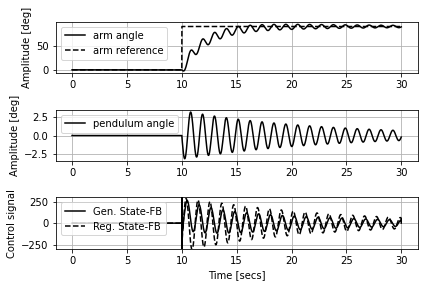

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
time = [float(t)*dt for t in range(1,time_steps+1)]
ax1.plot(time, x[0,:], 'k', time, arm_reference[0,:], 'k--')
ax1.legend(['arm angle', 'arm reference'], loc='upper left')
ax1.grid(True)
ax1.set(ylabel='Amplitude [deg]')

ax2.plot(time, x[2,:], 'k')
ax2.grid(True)
ax2.set(ylabel='Amplitude [deg]')
ax2.legend(['pendulum angle'], loc='upper left')

ax3.plot(time, u[0,:], 'k', time, uK[0,:], 'k--')
ax3.grid(True)
ax3.legend(['Gen. State-FB', 'Reg. State-FB'], loc='upper left')
ax3.set(xlabel='Time [secs]', ylabel='Control signal')
ax3.set_ylim([-300,300])
fig.tight_layout()